In [1]:
import os 
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import cv2
import numpy as np
import copy
import torchvision

In [2]:
folder = 'seen'
print(folder)

seen


# Data Reading

In [3]:
class GraspDataset(Dataset):
    def __init__(self, folder_dir, transform=None):
        self.folder_dir = folder_dir
        self.transform = transform
        self.image_dir = os.path.join(folder_dir, 'image')
        self.ginstruction_dir = os.path.join(folder_dir, 'grasp_instructions')
        self.glabel_dir = os.path.join(folder_dir, 'grasp_label')

        self.samples = os.listdir(self.image_dir)
        self.samples = [sample[:-4] for sample in self.samples]

        self.transform = transform
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        instance = self.samples[idx]
        
        image_path = os.path.join(self.image_dir, instance + '.jpg')
        image = Image.open(image_path).convert('RGB')
        image = np.asarray(image).copy()
        
        ginstruction_path = os.path.join(self.ginstruction_dir, instance + '_0_0.pkl')
        with open(ginstruction_path, 'rb') as ff:
            ginstruction = pickle.load(ff)
        
        glabel_path = os.path.join(self.glabel_dir, instance + '_0_0.pt')
        with open(glabel_path, 'rb') as ff:
            glabel = torch.load(ff)

        if self.transform:
            image = self.transform(image)
        
        return image_path, image, ginstruction, glabel

In [4]:
dataset = GraspDataset(folder)

At path: seen/image/7c1e40747d092c32cc0dc90cdb9fe372d45b27c9fd5c97238eb32b88406d7db8.jpg
--The instruction:
Grab sunglasses on its eyewear.
--The image:


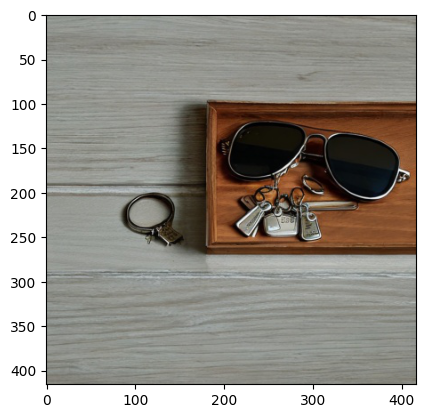

--The label:
tensor([[1.7622e-01, 3.4805e+02, 1.7732e+02, 1.6532e+02, 3.7644e+01, 1.7300e+02],
        [1.2843e-01, 3.4524e+02, 1.5411e+02, 1.1894e+02, 5.4142e+01, 7.6090e+00],
        [1.2802e-01, 3.6627e+02, 1.7909e+02, 1.3698e+02, 4.3567e+01, 1.7749e+02],
        [1.0370e-01, 3.4845e+02, 1.7962e+02, 1.5167e+02, 3.6588e+01, 1.0968e+01]])
--The grasp image:


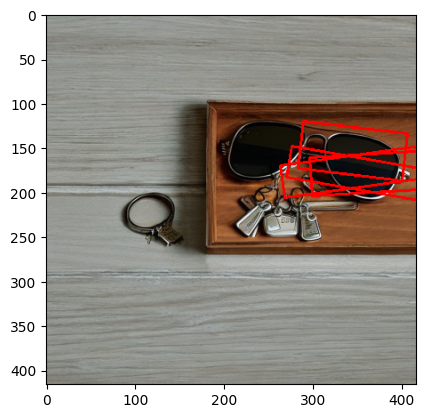

In [5]:
def visualize_grasp(image_path, image, ginstruction, glabel):
    if isinstance(image, torch.Tensor):
        image = torch.permute(image, (1, 2, 0)).numpy()
        
    def draw_rotated_rect(img, x, y, w, h, angle):
        img = img.copy()
        # Define the rectangle via its center, width, height, and rotation angle
        rect = ((x, y), (w, h), angle)
        box = cv2.boxPoints(rect)
        box = np.intp(box)  # Convert coordinates to integers
        
        # Draw the rectangle on the image
        cv2.drawContours(img, [box], 0, (255, 0, 0), 2)  # Blue color and 2 pixel thickness
        return img

    print("At path:", image_path)
    
    print("--The instruction:")
    print(ginstruction)
    
    print("--The image:")
    plt.imshow(image)
    plt.show()
    
    print("--The label:")
    print(glabel)
    
    # Draw each grasp pose on the image
    drawn_image = image
    for _, x, y, w, h, theta in glabel:
        x, y, w, h, theta = int(x), int(y), int(w), int(h), int(theta)
        drawn_image = draw_rotated_rect(drawn_image, x, y, w, h, theta)
    
    print("--The grasp image:")
    plt.imshow(drawn_image)
    plt.show()

image_path, image, ginstruction, glabel = dataset.__getitem__(0)
visualize_grasp(image_path, image, ginstruction, glabel)

In [6]:
# seen dataset has 1129 instances.
# unseen dataset has 138 instances.

# Data Loading

In [9]:
folder = 'unseen'

In [10]:
def custom_collate(batch): 
    # Separate features and labels
    names_batch = [item[0] for item in batch]
    images_batch = [item[1] for item in batch]
    instructions_batch = [item[2] for item in batch]
    labels_batch = [item[3] for item in batch]
      
    return names_batch, torch.stack(images_batch, dim=0), instructions_batch, labels_batch

# Create the data transformation functions
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Create an instance of the GraspDataset
dataset = GraspDataset(folder, transform=transforms)

# Define parameters for DataLoader
batch_size = 1
shuffle = False

# Create a DataLoader to efficiently load data in batches
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=custom_collate)

In [12]:
for datum in data_loader:
    image_paths, images, ginstructions, glabels = datum
    print(ginstructions)

['Grasp me the banana.']
['Grip hairbrush on its bristles.']
['Grab banana on its skin.']
['Pick up hairbrush by its bristles.']
['Grasp lamp at its base.']
['Pick up hairbrush by its bristles.']
['Grasp me the grape.']
['Grab banana on its skin.']
['Grab banana on its skin.']
['Hold banana at its skin.']
['Hold banana at its skin.']
['Grasp eggplant at its skin.']
['Hand me the banana']
['Grasp me the banana.']
['Grasp candle at its wax.']
['Grip hairbrush on its bristles.']
['Pick up hairbrush by its bristles.']
['Grip egg on its shell.']
['Grasp me the banana.']
['Hold banana at its skin.']
['Give me the candle']
['Grasp hairbrush at its bristles.']
['Hold hairbrush at its bristles.']
['Hand me the banana']
['Grasp pliers at its handles.']
['Pick up banana by its skin.']
['Grip banana on its skin.']
['Hand me the banana']
['Give me the hairbrush']
['Pick up banana by its skin.']
['Grab hairbrush on its bristles.']
['Grab hairbrush on its bristles.']
['Grip banana on its skin.']
['Pi